# Absorbed photon energy balance model

Formulated by Nozik et al. in 

## Solar absorption efficiency

In [1]:
#General parameters

h=4.135e-15 #Planck constant, eV*s
c=299.8e06 #Speed of light, m/s
q_e=1.602e-19 #Electrin charge, C
kB=8.617e-05 #Boltzman constant, eV/K
T=293 #Temperature, K
RedPlank=6.582e-16 #Reduced Planck constant, eV*s
R=8.314 #Gas constant, J/(K*mol)
F=96485.3321 #Faraday's constant, C/mol

In [ ]:
#Read the standard solar spectra and create the working dataframe

import pandas as pd
AM_15G=pd.read_excel('AM 15G.xlsx')

In [3]:
#Calculate the incident spectral photon flux

AM_15G['Incident spectral photon flux m-2*s-1*n-1']=AM_15G['Global tilt  W*m-2*nm-1']*AM_15G['Wvlgth nm']*1e-9/h/q_e/c

In [4]:
#Calculate absorbed photon flux (Equation S2)

from scipy import integrate
import numpy as np

incident_spectral_photon_flux=np.array(AM_15G['Incident spectral photon flux m-2*s-1*n-1'])
lamda=np.array(AM_15G['Wvlgth nm'])
absorbed_photon_flux=integrate.cumulative_trapezoid(y=incident_spectral_photon_flux, x=lamda)
AM_15G['absorbed_photon_flux, m-2 s-1']=pd.DataFrame(absorbed_photon_flux)


In [5]:
#Calculate the band gaps 

AM_15G['Eg eV']=h*c/AM_15G['Wvlgth nm']/1e-9
Eg_range=AM_15G['Eg eV']

In [6]:
#Calculate the Solar incident Power (Equation S1)

from scipy import integrate
import numpy as np

global_tilt=np.array(AM_15G['Global tilt  W*m-2*nm-1'])
solar_incident_power=integrate.simpson(y=global_tilt, x=lamda)
print(solar_incident_power)

1001.159375840659


In [7]:
#Calculate the solar absorption efficiency (Equation S3)

solar_absorption_efficiency=q_e*AM_15G['absorbed_photon_flux, m-2 s-1']*AM_15G['Eg eV']/solar_incident_power*100
AM_15G['Solar absorption efficiency, %']=pd.DataFrame(solar_absorption_efficiency)

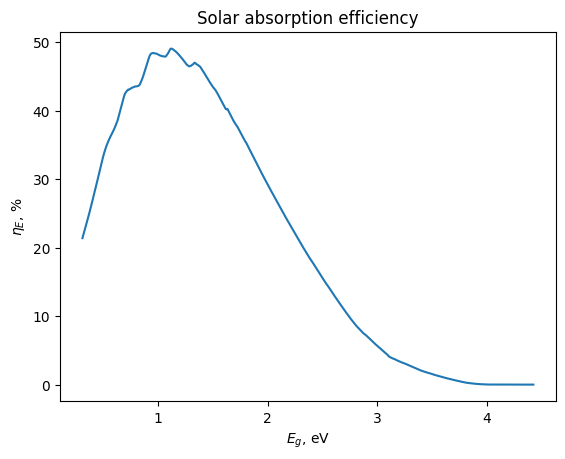

In [8]:
import matplotlib.pyplot as plt

Eg=np.array(AM_15G['Eg eV'])

plt.plot(Eg, solar_absorption_efficiency)
plt.xlabel(r'$E_{g}$, eV')
plt.ylabel(r'${\eta}_{E}$, %')
plt.title(r'Solar absorption efficiency')
plt.show()

In [9]:
#Write down the calculated data to excel file

AM_15G.to_excel('Solar absorption.xlsx')

## Idealized case (no losses)

In [10]:
# Reactions under investigation

E_H2O=1.23
E_MetOH=0.016
E_Acetic=0.098
E_Acetaldehyde=0.052
E_Urea=0.37

E_reaction=np.array([E_H2O,E_MetOH, E_Acetic,E_Acetaldehyde,E_Urea])

In [11]:
#In idealized case, all losses are assumed to be zero
#Thus, the minimum band gap required to drive electrochemical reaction

Eg_min_ideal=E_reaction

In [50]:
#Calculate chemical efficiency (Equation 3, main text of article)

chem_eff=E_reaction/Eg[:, None]
chem_eff[Eg[:, None] < Eg_min_ideal] = 0  #here we take into account that at Eg<Eg_min, the reaction can not be driven

In [51]:
#Calculate solar conversion efficiency (Equation 1, main text of article)

SCE_ideal=np.array(solar_absorption_efficiency)[:, None]*chem_eff

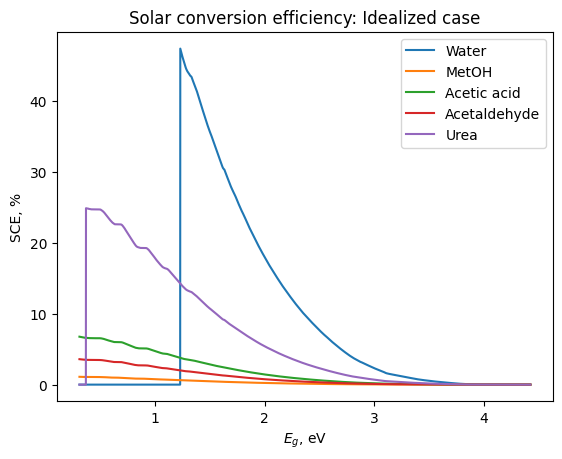

In [57]:
legend_id=['Water', 'MetOH', 'Acetic acid', 'Acetaldehyde' , 'Urea']
plt.plot(Eg, SCE_ideal, label=legend_id)
plt.legend(loc='best')
plt.xlabel(r'$E_{g}$, eV')
plt.ylabel(r'SCE, %')
plt.title(r'Solar conversion efficiency: Idealized case')
plt.show()

In [37]:
#Write down the calculated data in excel file

column_names=['Water', 'MetOH', 'Acetic acid', 'Acetaldehyde' , 'Urea']
APEB_ideal=pd.DataFrame(SCE_ideal, columns=column_names)
APEB_ideal.insert(0, 'Bandgap, eV', Eg)
APEB_ideal.to_excel('APEB_ideal_case.xlsx')


## Realistic case (kinetic limitations)

In [38]:
#Parameters

j0_cat=10 # cathodic exchange current density, A/m2
f_abs=0.9 # fraction of absorbed photons
alfa=0.5 # electron transfer coefficient

In [39]:
#Exchange current density for the reactions under investigation experimentally estimated in the literature

j0_an_H2O=10e-04
j0_an_MetOH=10
j0_an_Acetic=7.9e-02
j0_an_Acetaldehyde=2.76e-04
j0_an_Urea=7.14e-02

j0_an_reaction=np.array([j0_an_H2O, j0_an_MetOH, j0_an_Acetic, j0_an_Acetaldehyde, j0_an_Urea])

In [40]:
#Number of electrons participating in the elementary step of electrochemical reaction

n_e_H2O=2
n_e_MetOH=2
n_e_Acetic=2
n_e_Acetaldehyde=2
n_e_Urea=2

n_e_reaction=np.array([n_e_H2O, n_e_MetOH, n_e_Acetic, n_e_Acetaldehyde, n_e_Urea])

In [44]:
#Losses

V_b=0.2 #Band banding energy, i. e. the energy spent for the electron-hole separation, eV
E_loss_et=0.2 #Energy spent pn electron transfer from conduction band of semiconductor to Fermi level of metal, eV
eiR=0.05 #Ohmic losses, eV

In [ ]:
#Calculate minimum bandgap

def Eg_min(E0, n_e, j0_an, j):
    etta_cat=R*T/alfa/2/F*np.arcsinh(j/2/j0_cat) #cathodic ovetpotential
    etta_an=R*T/alfa/n_e/F*np.arcsinh(j/2/j0_an) #anodic overpotential

    return E0+V_b+E_loss_et+eiR+etta_cat+etta_an

j_max=500 #photocurrent at Eg=1 eV

vec=np.vectorize(Eg_min)

Eg_min_real=vec(E_reaction, n_e_reaction, j0_an_reaction, j=j_max)

array([2.11008375, 0.66355686, 0.86776663, 0.96458607, 1.1423204 ])

In [53]:
#Calculate chemical efficiency (Equation 3, main text of article)

chem_eff_real=E_reaction/Eg[:, None]
chem_eff_real[Eg[:, None] < Eg_min_real] = 0

In [54]:
#Calculate solar conversion efficiency (Equation 1, main text of article)

SCE_real=np.array(solar_absorption_efficiency)[:, None]*chem_eff_real

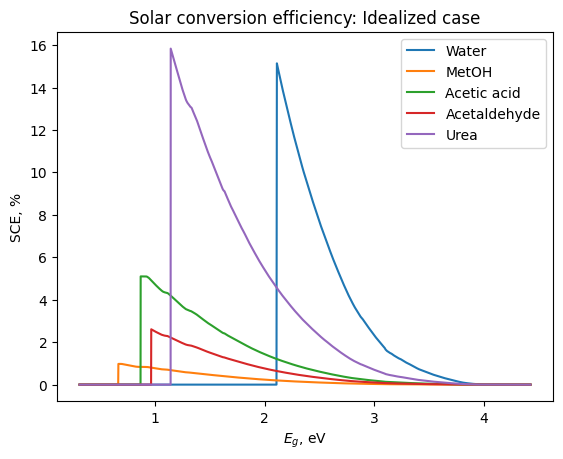

In [58]:
legend_real=['Water', 'MetOH', 'Acetic acid', 'Acetaldehyde' , 'Urea']
plt.plot(Eg, SCE_real, label=legend_real)
plt.legend(loc='best')
plt.xlabel(r'$E_{g}$, eV')
plt.ylabel(r'SCE, %')
plt.title(r'Solar conversion efficiency: Idealized case')
plt.show()

In [56]:
#Write down the calculated data in excel file

column_names=['Water', 'MetOH', 'Acetic acid', 'Acetaldehyde' , 'Urea']
APEB_real=pd.DataFrame(SCE_real, columns=column_names)
APEB_real.insert(0, 'Bandgap, eV', Eg)
APEB_real.to_excel('APEB_ideal_case.xlsx')

## Hydrogen production flux

In [59]:
#Avogadro number

N_A=6.022e23

In [67]:
#Calculate hydrogen flux

hydrogen_flux=absorbed_photon_flux/2/N_A #mol m-2 s-1
hydrogen_flux=hydrogen_flux*1000*3600/10000 #mmol cm-2 h-1
AM_15G['hydrogen flux, mmol cm-2 h-1']=pd.DataFrame(hydrogen_flux)

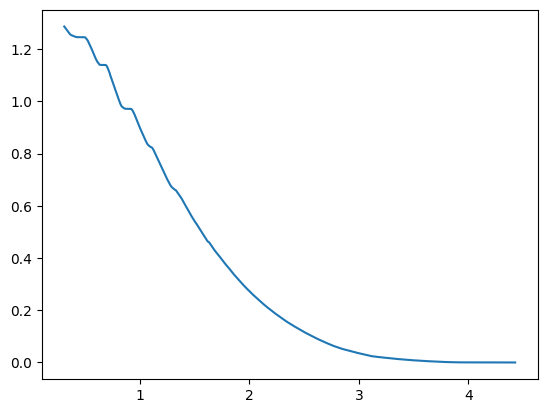

In [68]:
plt.plot(Eg[:-1], hydrogen_flux)
plt.show()

In [ ]:
#Maximum theoretical hydrogen flux at given bandgap

Eg_value = 2.4  

idx = np.abs(Eg - Eg_value).argmin()

closest_Eg = Eg[idx]
corresponding_flux = hydrogen_flux[idx]

print("Closest Eg", closest_Eg, 'eV')
print("Hydrogen flux", corresponding_flux, "mmol/(m^2 h)")

Closest Eg 2.3978201160541586 eV
Hydrogen flux 0.14150132626696849 mmol/(m^2 h)


In [77]:
#Write down the calculated data to excel file

AM_15G.to_excel('Solar absorption.xlsx')